# Assignment 1


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas. For handwritten or other submissions, convert to PDF and upload the resulting document to Canvas.*

## Group Members

*Group submission with up to 3 students is highly encouraged. If you submit as part of group, list all group members with their contributions to this assignment, e.g.*

* Mark Forese (Solved Problem 1, LaTeX'ed problem 2)
* Shai Slav (Solved Problem 2, checked solution on Problem 1)

---

## Problem 1: Star Chart (4pts)

The best way to orient yourself at the night sky is a map. Let's make one. The data file `constellation.pkl` for this assignment contains a stellar catalog (with RA, Dec, visible magnitude columns), grouped by the official abbreviation of the constellation name in the form of a python dictionary. It can be loaded and unpacked with the method `read_file` provided below.

Use the methods from `astropy.coordinates` to compute the star chart in the Alt-Az (local horizon) frame for midnight on the night of September 16, 2020 as observed from your location on Earth. [This](https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html) example should help.

**Hint:** Use the [`polar` coordinate plot](https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/polar_scatter.html) from matplotlib, remove stars with negative altitude, and chose the size of each stars according to its magnitude (larger magnitude means fainter). If you can, look at the sky outside and validate (using time and date as needed).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

def read_file(filename = "constellation.pkl"):
    with open(filename, "rb") as fp:
        constellation = pickle.load(fp)
        return constellation

constellations = read_file()
#constellations #viewing some of the dataset

*Looking at this dictionary, we see that each key is an abbreviation for a constellation. Each value is a nested array, containing the RA, Dec, and visible magnitude (M<sub>V</sub>) for several objects.*

**Assumption: These coordinates are in the ICRS frame. This will matter for creating the SkyCoord Object**

*If the line printing the dict is commented out, it's  just for the sake of cleanliness*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord,AltAz,EarthLocation
import astropy.units as u
from astropy.time import Time


#fixing random state for reproducability
np.random.seed(42)

#first, let's make a list of the specific objects (i.e. a list of those subarrays from constellations)
objects_raDec = [] #this will end up being a list of SkyCoord objects
mags = []

for value in constellations.values():
    for i in range(len(value)):
        ra = value[i][0]*u.degree #right ascension value in degrees
        dec = value[i][1]*u.degree #declination value in degrees
        mag = value[i][2] #brightness in magnitudes
        coords = SkyCoord(ra = ra, dec = dec, frame = 'icrs')
        
        objects_raDec.append(coords)
        mags.append(mag)
        
print(objects_raDec[0])
print(mags[0])

<SkyCoord (ICRS): (ra, dec) in deg
    (2.09715, 29.0906)>
2.06


# Now, we want to switch to the Alt-Az frame
* To do that, first we need to define where exactly we are on the Earth (since our location defines our coordinate system)
* We do this using an `EarthLocation` object
* I'm currently in Sugar Mountain, NC, which has coordinates of: 36.1273° N, 81.8601° W, h = 5,300 ft (1615 m)
* Let's make an `EarthLocation` object called `sugarMountain`, and do this at the time of midnight EDT (4 AM UTC) on September 16, 2020

In [3]:
sugarMountain = EarthLocation(lat = 36.12 * u.degree, lon = -81.86*u.degree,height = 5300*u.imperial.ft)
utc_offset = -4*u.hour #UTC offset for Eastern Daylight Time
midnight_local = Time('2020-9-16 04:00:00') - utc_offset

In [4]:
# transforms each object in objects_raDec into Alt-Az coordinates at the given location and time
objects_altAz = [obj.transform_to(AltAz(obstime = midnight_local, location = sugarMountain)) for obj in objects_raDec]

#list comprehension checks if the altitude of an object is non-negative
# if so it adds it to be visible above our horizon
objs_above_horizon = [[obj.alt,obj.az] for obj in objects_altAz if obj.alt >=0]

In [5]:
def random_color():
    '''Creates a random color by making three random RBG values. Used in the plot_constellation function'''
    
    r = np.random.random()
    b = np.random.random()
    g = np.random.random()
    
    color = [r,b,g]
    return color

def plot_constellation(ax,abreviation,color = None):
    '''
    Takes in an abbreviation for a constellation and plots it on the axis ax.
    
    Parameters:
    
        Ax: axis object
            The axis on which we will plot the constellation
        
        Abreviation: string
            String representation of a constellation name, as given in the dataset `constelations`
    
        Color: string, default None
            The color in which to plot the constellation. If it is None, a random color will be generated.
    
    Returns: 
        Technically None, but plots the constellation
    '''
    
    #just to see what a constellation I know looks like, lets look for Ursa Major
    # it has the key UMa
    constel = constellations[abreviation]
    #print(big_dipper)

    constel_objs = []
    constel_mags =[]
    for i in range(len(constel)):
        ra = constel[i][0]
        dec = constel[i][1]
        mag = constel[i][2]

        coords = SkyCoord(ra = ra*u.degree, dec = dec*u.degree,frame = 'icrs')
        constel_objs.append(coords)
        constel_mags.append(mag)

    constel_horizonFrame = [obj.transform_to(AltAz(obstime = midnight_local, \
                                        location = sugarMountain))for obj in constel_objs]

    objs_above_horizon = [[obj.alt,obj.az] for obj in constel_horizonFrame if obj.alt >=0]

    #we have to chop off the units of each of these for .scatter to work
    
    #90- all the altitude values essentially flips the axis. I do this to plot the 
    # center of the polar axis at 90 and the edges at 0, while .scatter makes you 
    # increase your value from center to rim (since it's technically a radius the way 
    #its plotted) this flips the coordinates, but I switch the tick lables below
    alts = abs(90-np.array([obj[0].value for obj in objs_above_horizon]))
    azs_deg = [obj[1].value for obj in objs_above_horizon] 
    
    #we have to convert the azimuth angles to radians
    azs_rads = [az_deg*np.pi/180 for az_deg in azs_deg]
    
    #magnitude array to get the sizes of the points
    # I do a transformation to make all lower magnitude stars have higher values, 
    # and add a translation to make sure all the stars show up
    constel_mags_arr = np.array(constel_mags)
    
    mags_arr = max(constel_mags_arr) - constel_mags_arr+0.5
    

    if color is None:
        color = random_color() #making a random color for the plot
    
    #and here we plot on the given axis
    ax.scatter(azs_rads,alts, s= mags_arr,c = color,label = abreviation)

10.08 -2.205
12.785 0.5


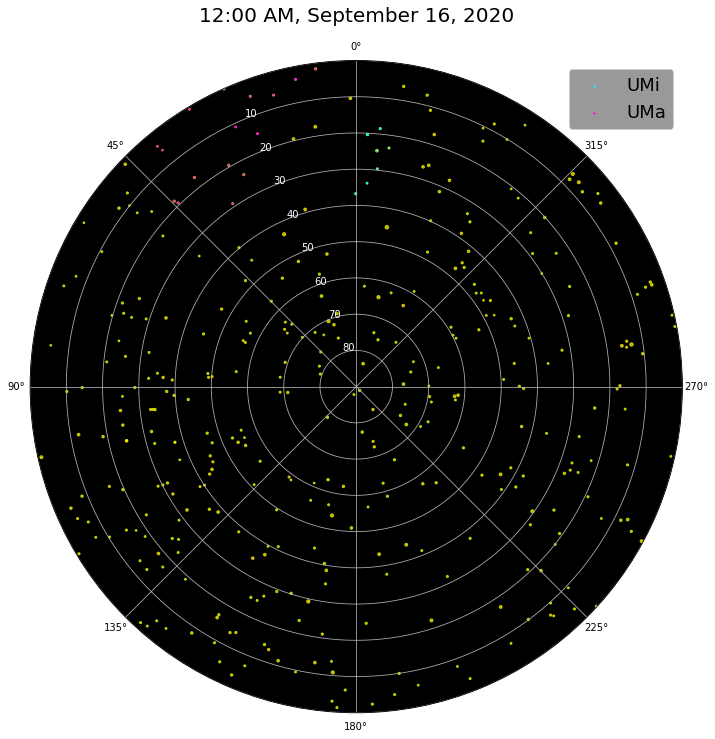

In [6]:
#print(objs_above_horizon)

fig = plt.figure(figsize = (16,12))
ax = fig.add_subplot(111,projection='polar')

#we have to chop off the units of each of these for .scatter to work
azs_deg = [obj[1].value for obj in objs_above_horizon] 

#90- all the altitude values essentially flips the axis. I do this to plot the center of 
#the polar axis at 90 and the edges at 0, while .scatter makes you increase your value 
# from center to rim (since it's technically a radius the way its plotted)
# this flips the coordinates, but I switch the tick lables below
alts = abs(90-np.array([obj[0].value for obj in objs_above_horizon]))

#we have to convert the azimuth angles to radians
azs_rads = [az_deg*np.pi/180 for az_deg in azs_deg]

# magnitude array to get the sizes of the points
# I do a transformation to make all lower magnitude stars have higher values, 
# and add a translation to make sure
# all the stars show up
mags_arr = 1.5*np.array(mags)
print(max(mags_arr),min(mags_arr))
mags_arr = max(mags_arr) - mags_arr+0.5
print(max(mags_arr),min(mags_arr))

ax.scatter(azs_rads,alts, s= mags_arr,c = 'yellow',alpha = 0.7)


#and let's do Ursa Minor
# it has the key UMi
plot_constellation(ax,'UMi','cyan')

plot_constellation(ax,'UMa','magenta')

ax.set_rmax(90)
ax.set_theta_zero_location('N')
ax.set_ylim(0, 90)
# setting the tick lables to be 90 in the center, so that it corresponds with the actual 
# sky (and what we're plotting)
ax.set_yticklabels(labels = [i for i in range(80,-10,-10)],color = 'w')
ax.set_facecolor('black')

ax.set_title('12:00 AM, September 16, 2020', fontsize = 20)
plt.legend(fontsize = 18,facecolor = 'gray')

plt.show()

I chose to plot Ursa Major and Ursa Minor for two reasons:
<ol>
    <li> The tip star of Ursa Minor, Polaris, should be on the azimuth of 0 degrees (North) and an altitude equal to my lattitude. Plotting that constellation let me check that. </li>
    <li> I know the shapes of the two constellations, so being able to see them clearly was a good check for my code. I also know that the bottom two stars in the 'pan' of Ursa Major point roughly at Polaris. (This is actually how I debugged my code) </li>
</ol>

## Problem 2: Telescope Design (6pts)

We're in the year 1934. You get a phone call from George Hale, who tells you that he is building the largest telescope in the world with a $D_1=5.1\,\mathrm{m}$ primary mirror. He wants you to build the secondary mirror for a Cassegrain configuration with these specifications:

1. focal length of the primary mirror $f_1 = 16.8\,\mathrm{m}$
2. distance from primary to secondary mirror $d=13.8\,\mathrm{m}$
2. combined focal length $f=81.3\,\mathrm{m}$

### Question 1

What is the diameter $D_2$ of the secondary mirror?

**Hint:** Compare to Chromey Fig. 5.17. Make a sketch of the Cassegrain configuration and follow parallel rays from the primary mirror.

From Chromey Figure 5.17, we can draw triangles to show that:

$$\tan\left(\frac{D_1 - D_2}{2\,d_{12}}\right) \: = \: \tan\left(\frac{D_1}{2\,f_1}\right)$$


where f<sub>1</sub> is the primary focal length, D<sub>1</sub> is the diameter of the primary mirror, D<sub>2</sub> is the diameter of the secondary mirror, and d<sub>12</sub> is the distnace between the two mirrors. Rearranging for D<sub>2</sub>:

$$D_2 = D_1 \cdot \left(1 - \frac{d_{12}}{f_1}\right) $$


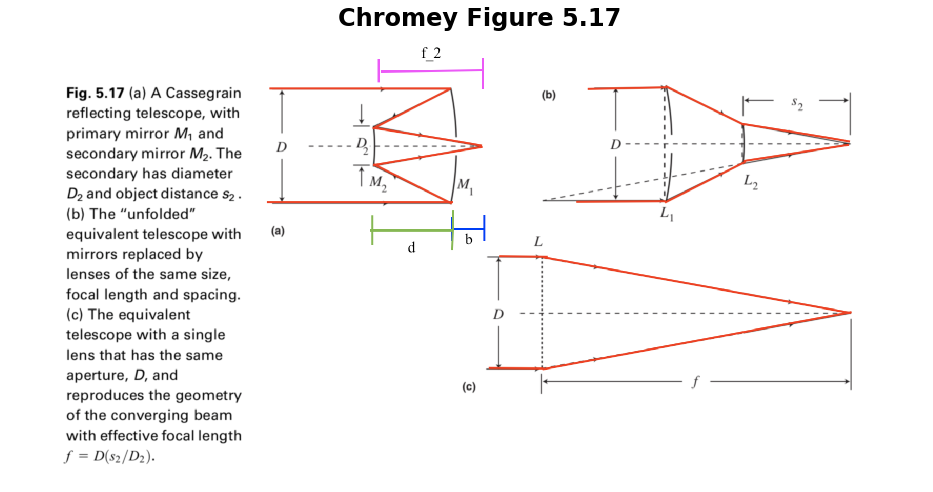

In [7]:
import matplotlib.image as mpimg 

fig = plt.figure(figsize = (16,12))
ax = plt.subplot(111)
#reading in image to show the geometry of the problem 
img = mpimg.imread('./chromey_fig_517.png') 
  
# Output Images
ax.set_axis_off()
ax.set_title('Chromey Figure 5.17',fontsize = 24,fontweight = "bold")
ax.imshow(img) 


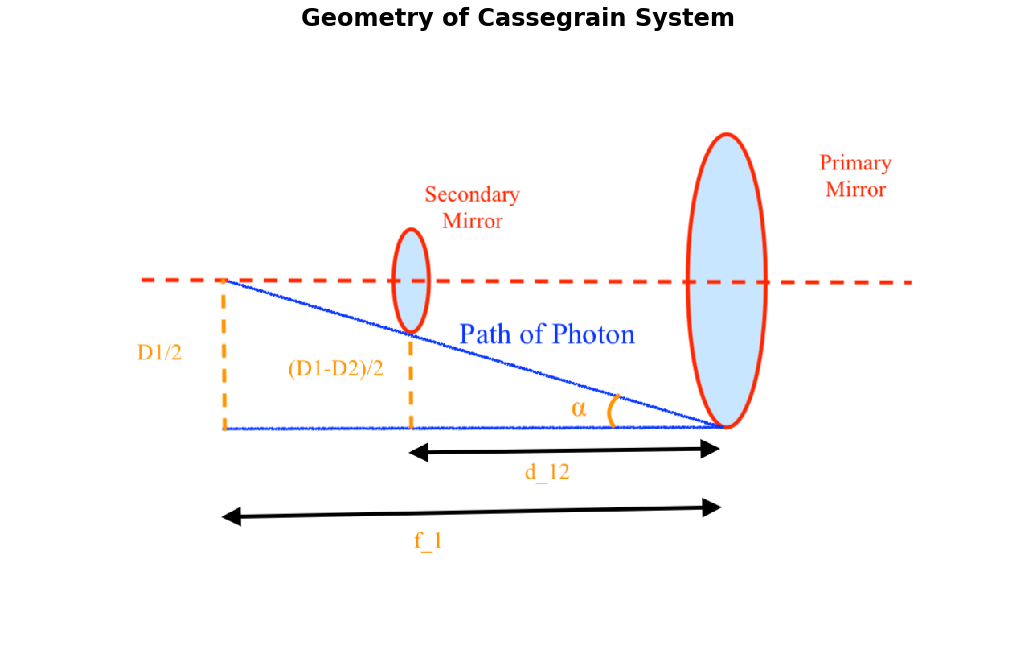

In [8]:
fig = plt.figure(figsize = (32,24))
ax_2 = plt.subplot(212) 
img_2 = mpimg.imread('./mirror_model.png') 
ax_2.set_axis_off() 
ax_2.set_title('Geometry of Cassegrain System',fontsize = 24,fontweight = 'bold')
ax_2.imshow(img_2)

In [9]:
#defining given variables
f_1 = 16.8 *u.m
f_tot = 81.3*u.m
d_12 = 13.8*u.m
D_1 = 5.1 *u.m

D_2 = D_1 *(1 - d_12/f_1 )
print(r'Diameter of the secondary mirror = {:.3f}'.format(D_2))

Diameter of the secondary mirror = 0.911 m


### Question 2

What is the focal length $f_2$ of the secondary mirror?

**Hint:** The power of a mirror that reflects light back towards its origin is negative.

The total power of a telescope with multiple optical elements is given by:

$$P_{tot} = P_{12} + P_{23} - \frac{d}{n_2}P_{12}P_{23}$$

where P<sub>12</sub> = 1 / f<sub>1</sub> is the power of the first mirror, P<sub>23</sub> 1 / f<sub>2</sub> is the power of the second mirror, d is the distance between the two mirrors, and n<sub>2</sub> is the index of refraction for the medium in which the light is travelling in the telescope. In air, we approximate d = 1. 

$$P_{tot} \equiv \frac{1}{f_{tot}} = \frac{1}{f_1} + \frac{1}{f_2} - d\frac{1}{f_1}\frac{1}{f_2}$$

Rearranging for f<sub>2</sub>:

$$f_2 = \frac{\left(1 - \frac{d_{12}}{f_1}\right)}{\left(\frac{1}{f_{tot}} -\frac{1}{f_1}\right)}$$

In [10]:
f_2 = (1 - d_12 / f_1)/ (1/f_tot - 1/f_1)

print('The focal length of the secondary = {:.2f}'.format(f_2))

The focal length of the secondary = -3.78 m


### Question 3

How far past the vertex of the primary mirror does the image for the Cassegrain configuration form?

**Hint:** See Chromey Fig. 5.17 again.

We define the value in question as b. Looking at the drawing, we see that 
$$b = \:  s_{2} - \:d_{12}$$

From Chromey 5.17:

$$s_2 = \left(\frac{D_2}{D_1}\right)f_{tot}$$

In [12]:
s_2 = D_2/D_1*f_tot

b = s_2 - d_12

print('Distance from the vertex of the primary mirror to the image = {:.3f}'.format(b))

Distance from the vertex of the primary mirror to the image = 0.718 m
